<a href="https://colab.research.google.com/github/bacoco/LLM-Finetuning/blob/main/ColPali_%2B_Qwen2_VL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal RAG using ColPali (with Byaldi) and Qwen2-VL and Argilla

[ColPali](https://huggingface.co/blog/manu/colpali) is a multimodal retriever that removes the need for hefty and brittle document processors. It natively handles images and processes and encodes image patches to be compatible with text, thus removing need to do OCR, or image captioning.

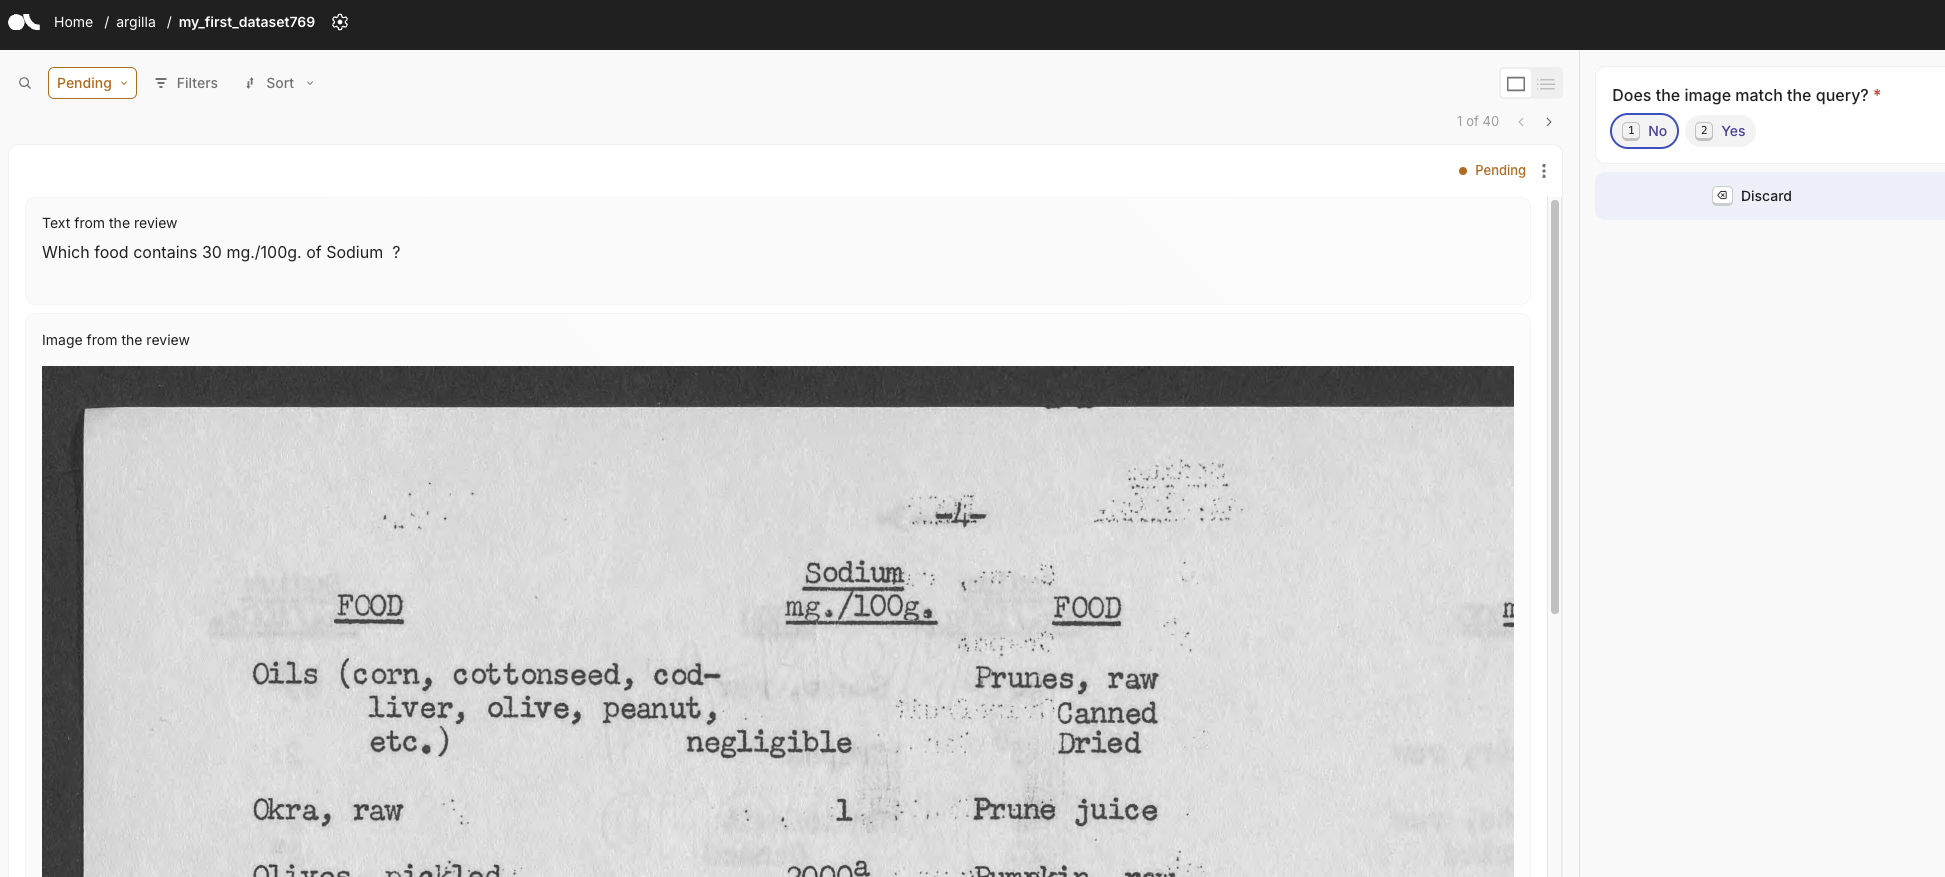

![ColPali](https://cdn-uploads.huggingface.co/production/uploads/60f2e021adf471cbdf8bb660/La8vRJ_dtobqs6WQGKTzB.png)

After indexing data, we will use [Qwen2-VL-7B](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) to do generation part in RAG.

[Byaldi](https://github.com/AnswerDotAI/byaldi) is a new library by answer.ai to easily use ColPali. This library is in a very early stage, so this notebook will likely be updated soon with API changes.

## Install Byaldi

We will install byaldi from source to get started.

In [ ]:
!sudo apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (146 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123597 

In [ ]:
!pip install git+https://github.com/AnswerDotAI/byaldi.git git+https://github.com/huggingface/transformers.git qwen-vl-utils flash-attn optimum auto-gptq bitsandbytes argilla

  Cloning https://github.com/AnswerDotAI/byaldi.git to /tmp/pip-req-build-8wq63sq_
  Running command git clone --filter=blob:none --quiet https://github.com/AnswerDotAI/byaldi.git /tmp/pip-req-build-8wq63sq_
  Resolved https://github.com/AnswerDotAI/byaldi.git to commit b1d9aa6231821408a0aec0befe4ac4c86b4f17dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-2s1fu70u
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-2s1fu70u
  Resolved https://github.com/huggingface/transformers.git to commit e48e5f1f13e05380e24f4f31f5fee07aa6f959eb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for Byaldi: filename=Byaldi-0.0.2-py3-none-any.whl size=20364 sha256=79c

We need to install transformers from main to get Qwen.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git qwen-vl-utils flash-attn optimum auto-gptq bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 16.3 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# RAG Application

We should initialize `RAGMultiModalModel` object with a ColPali model from Hugging Face. By default this model uses GPU but we are going to have Qwen2-VL in the same GPU so we are loading this in CPU for now.

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")

model = Qwen2VLForConditionalGeneration.from_pretrained(
       "Qwen/Qwen2-VL-7B-Instruct",
       torch_dtype=torch.bfloat16,
       attn_implementation="flash_attention_2",
       device_map="auto",
       trust_remote_code=True
    ).cuda().eval()
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", trust_remote_code=True)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

We can directly index our document using RAG, simply passing pdf file path is enough.

In [ ]:
from datasets import load_dataset
import os

ds = load_dataset("burtenshaw/document-similarity")
MAX_SAMPLES = 5
image_dir = "images"
os.makedirs(image_dir, exist_ok=True)
results = []

for idx, sample in enumerate(ds["train"].select(range(MAX_SAMPLES))):
    image_path = os.path.join(image_dir, f"{idx}.png")
    sample["image"].save(image_path)
    RAG.index(
        input_path=image_path,
        index_name="image_index", # index will be saved at index_root/index_name/
        store_collection_with_index=False,
        overwrite=True
    )


overwrite is on. Deleting existing index image_index to build a new one.


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Added page 1 of document 0 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index
overwrite is on. Deleting existing index image_index to build a new one.
Added page 1 of document 1 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index
overwrite is on. Deleting existing index image_index to build a new one.
Added page 1 of document 2 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index
overwrite is on. Deleting existing index image_index to build a new one.
Added page 1 of document 3 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index
overwrite is on. Deleting existing index image_index to build a new one.
Added page 1 of document 4 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


Let's define a function to do RAG on our dataset.

In [ ]:
from PIL import Image

def document_rag(text_query, image):

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image,
                },
                {"type": "text", "text": text_query},
            ],
        }
    ]
    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")
    generated_ids = model.generate(**inputs, max_new_tokens=50)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text

# Add results to Argilla

Now we can add our search results to Argilla for review.

In [ ]:
from random import randint

import argilla as rg

client = rg.Argilla(
    api_url="https://burtenshaw-argilla-template-space.hf.space",
    api_key="<api_key>"
)

In [ ]:
settings = rg.Settings(
    guidelines="Classify the reviews as positive or negative.",
    fields=[
        rg.TextField(
            name="text",
            title="Question that relates to the document image",
            use_markdown=False,
        ),
        rg.ImageField(
            name="image",
            title="Image of the document",
        ),
        rg.TextField(
            name="answer",
            title="Answer",
            use_markdown=False,
        ),
    ],
    questions=[
        rg.LabelQuestion(
            name="match",
            title="Does the image match the query?",
            labels={"0": "No", "1": "Yes"},
        )
    ],
)
dataset = rg.Dataset(
    name=f"RAG_dataset{randint(0,1000)}",
    settings=settings,
    client=client,
)
dataset.create()

/usr/local/lib/python3.10/dist-packages/argilla/datasets/_resource.py:203: UserWarning: Workspace not provided. Using default workspace: argilla id: 5444f7bb-4e6c-4ea2-a30c-7e91ca289bee
  warnings.warn(f"Workspace not provided. Using default workspace: {workspace.name} id: {workspace.id}")


Dataset(id=UUID('1e2325ed-19ac-4fcb-a6a4-bef50bfd55f4') inserted_at=datetime.datetime(2024, 9, 6, 13, 16, 17, 189046) updated_at=datetime.datetime(2024, 9, 6, 13, 16, 19, 69505) name='RAG_dataset543' status='ready' guidelines='Classify the reviews as positive or negative.' allow_extra_metadata=False distribution=OverlapTaskDistributionModel(strategy='overlap', min_submitted=1) workspace_id=UUID('5444f7bb-4e6c-4ea2-a30c-7e91ca289bee') last_activity_at=datetime.datetime(2024, 9, 6, 13, 16, 19, 69505))

In [ ]:
records = []
for sample in ds["train"].select(range(MAX_SAMPLES)):
    answer = document_rag(sample["text"], sample["image"])
    sample["answer"] = answer[0]
    records.append(sample)


In [ ]:
dataset.records.log(records)

/usr/local/lib/python3.10/dist-packages/argilla/records/_mapping/_mapper.py:89: UserWarning: Keys ['label'] in data are not present in the mapping and will be ignored.
  warnings.warn(f"Keys {unknown_keys} in data are not present in the mapping and will be ignored.")


DatasetRecords: The provided batch size 256 was normalized. Using value 2.

Sending records...: 100%|██████████| 1/1 [00:04<00:00,  4.85s/batch]


DatasetRecords(Dataset(id=UUID('1e2325ed-19ac-4fcb-a6a4-bef50bfd55f4') inserted_at=datetime.datetime(2024, 9, 6, 13, 16, 17, 189046) updated_at=datetime.datetime(2024, 9, 6, 13, 16, 19, 69505) name='RAG_dataset543' status='ready' guidelines='Classify the reviews as positive or negative.' allow_extra_metadata=False distribution=OverlapTaskDistributionModel(strategy='overlap', min_submitted=1) workspace_id=UUID('5444f7bb-4e6c-4ea2-a30c-7e91ca289bee') last_activity_at=datetime.datetime(2024, 9, 6, 13, 16, 19, 69505)))